In [ ]:
!nvidia-smi

In [2]:
import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")

!pip install yt-dlp qwen-vl-utils flash-attn --no-build-isolation accelerate
# Clean up the notebook
clean_notebook()



Notebook cleaned.


In [3]:
from yt_dlp import YoutubeDL

YOUTUBE_URL = "https://www.youtube.com/watch?v=MCWJNOfJoSM"

ydl_opts = {
    "format": "best",
    "outtmpl":"football.mp4"
    }
with YoutubeDL(ydl_opts) as ydl:
    ydl.download([YOUTUBE_URL])

[youtube] Extracting URL: https://www.youtube.com/watch?v=MCWJNOfJoSM
[youtube] MCWJNOfJoSM: Downloading webpage
[youtube] MCWJNOfJoSM: Downloading ios player API JSON
[youtube] MCWJNOfJoSM: Downloading mweb player API JSON
[youtube] MCWJNOfJoSM: Downloading player 03dbdfab
[youtube] MCWJNOfJoSM: Downloading m3u8 information
[info] MCWJNOfJoSM: Downloading 1 format(s): 18
[download] Destination: football.mp4
[download] 100% of   39.07MiB in 00:00:01 at 26.93MiB/s    


# Display Video

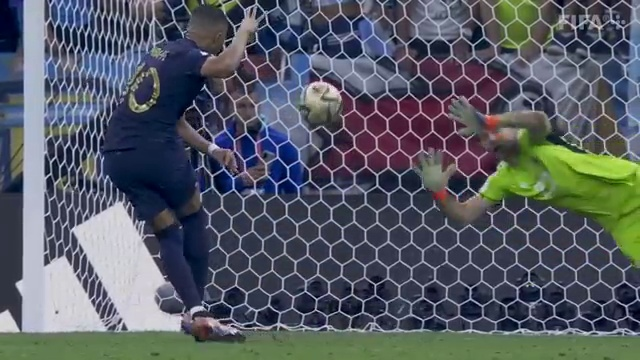

In [ ]:
import cv2
from IPython.display import display, Image, clear_output
import numpy as np

# Open the video file
cap = cv2.VideoCapture('./football.mp4')

if not cap.isOpened():
    print("Cannot open video file")
    exit()

while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        print("Stream stopped.")
        break

    # Convert the frame to JPEG format for display in Jupyter
    _, buffer = cv2.imencode('.jpg', frame)
    img_bytes = buffer.tobytes()

    # Display the frame in Jupyter Notebook
    display(Image(data=img_bytes))
    clear_output(wait=True)  # Clear previous frame for smoother playback

  
    
cap.release()
print("Video stream ended.")

# Memory Save

In [7]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor, BitsAndBytesConfig
from qwen_vl_utils import process_vision_info
import torch
from IPython.display import display, HTML


MODEL_NAME = "Qwen/Qwen2-VL-7B-Instruct"

# Define the quantization configuration
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Change to `load_in_8bit=True` for 8-bit quantization
    bnb_4bit_use_double_quant=True,  # Use double quantization for better accuracy
    bnb_4bit_quant_type="nf4",       # NormalFloat4 (nf4) quantization type
    bnb_4bit_compute_dtype=torch.float16  # Compute in float16 for lower memory
)

# Load the model with quantization
model = Qwen2VLForConditionalGeneration.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    quantization_config=quantization_config,  # Pass quantization config
    device_map="auto",
    attn_implementation="flash_attention_2",
)

# Load the processor
processor = AutoProcessor.from_pretrained(MODEL_NAME)


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "video",
                "video": "football.mp4",
                "max_pixels": 1280 * 780,
                "fps": 0.1,
            },
            {"type": "text", "text": "What's happening in the video? who wins the penalty shootout?."},
        ],
    }
]

text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

image_inputs, video_inputs = process_vision_info(messages)

inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

generated_ids = model.generate(**inputs, max_new_tokens=512)

generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]

output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

display(HTML("".join(output_text)))

# Full 

In [3]:
%time

from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
from IPython.display import display, HTML

MODEL_NAME = "Qwen/Qwen2-VL-7B-Instruct"

model = Qwen2VLForConditionalGeneration.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    attn_implementation="flash_attention_2",
)

processor = AutoProcessor.from_pretrained(MODEL_NAME)


# Display success message
display(HTML("<h3 style='color: green;'>Model and processor successfully loaded.</h3>"))

CPU times: user 1e+03 ns, sys: 1 μs, total: 2 μs
Wall time: 3.34 μs


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
%time

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "video",
                "video": "football.mp4",
                "max_pixels": 1280 * 780,
                "fps": 0.1,
            },
            {"type": "text", "text": "What's happening in the video? who wins the penalty shootout?."},
        ],
    }
]

text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

image_inputs, video_inputs = process_vision_info(messages)

inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

generated_ids = model.generate(**inputs, max_new_tokens=512)

generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]

output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

display(HTML("".join(output_text)))

CPU times: user 4 μs, sys: 1e+03 ns, total: 5 μs
Wall time: 12.2 μs


qwen-vl-utils using torchvision to read video.
